<a href="https://www.kaggle.com/code/aligreualihassan/text-classification-with-deep-learning?scriptVersionId=126866995" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv", header=None)
df.columns = ['label', 'text']
df.head()

,label,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [3]:
df.shape

(50425, 2)

In [4]:
df.isna().sum()

label    0
text     1
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.duplicated().sum()

22622

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.shape

(27802, 2)

the class distribution 

 Household                 10564
Books                      6256
Clothing & Accessories     5674
Electronics                5308
Name: label, dtype: int64





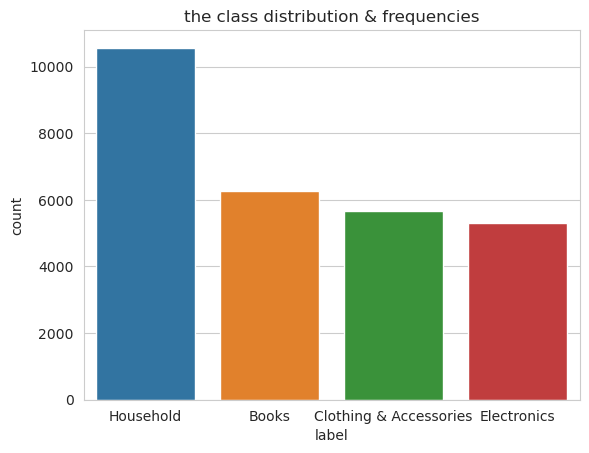

In [9]:
print("the class distribution \n\n", df.label.value_counts())

print("\n\n")

sns.countplot(data=df, x="label")
plt.title("the class distribution & frequencies")
plt.show()

## Text cleanig

In [10]:
df.label.nunique()

4

## Process the data for modeling

In [11]:
text = df.text
label = df.label

tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(text)

vocab_size = len(tokenizer.word_index) + 1
vocab_size
print("the vocab size is {}".format(vocab_size))

the vocab size is 92268


In [12]:
text

0        Paper Plane Design Framed Wall Hanging Motivat...
1        SAF 'Floral' Framed Painting (Wood, 30 inch x ...
2        SAF 'UV Textured Modern Art Print Framed' Pain...
3        SAF Flower Print Framed Painting (Synthetic, 1...
4        Incredible Gifts India Wooden Happy Birthday U...
                               ...                        
50402    Micromax Bharat 5 Plus Zero impact on visual d...
50403    Microsoft Lumia 550 8GB 4G Black Microsoft lum...
50407    Microsoft Lumia 535 (Black, 8GB) Colour:Black ...
50408    Karbonn Titanium Wind W4 (White) Karbonn Titan...
50410    Nokia Lumia 530 (Dual SIM, Grey) Colour:Grey  ...
Name: text, Length: 27802, dtype: object

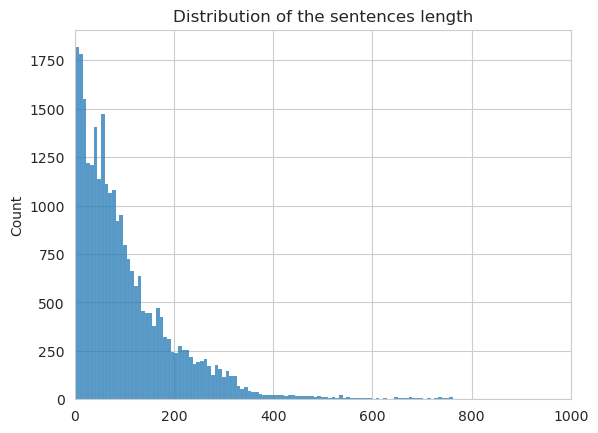

In [13]:
sent_length = np.array([len(sent.split()) for sent in text.to_list()])
sns.histplot(sent_length)
plt.xlim(0,1000)
plt.title("Distribution of the sentences length")
plt.show()

max_length = 400

In [14]:
token_to_seq = tokenizer.texts_to_sequences(text)

padded_text = keras.preprocessing.sequence.pad_sequences(token_to_seq,
                                                         truncating='post',
                                                         padding='post',
                                                         maxlen=max_length)

padded_text[:1]

array([[  325,  3582,    54,  6151,   153,   685,  6332,   241,   404,
          344,  1555,   106,   119,    32,   106,   119,   107,    33,
            3,    48,  1556,    40,    44,     7,  2657,   475,     8,
          844,  2827,   396,    45,   254,   239,  1906,     2, 10101,
         2080,    12,    13,     9,    24,   342,   385,     3,  5673,
           45,   118,    10,   153,   115,   220,     2,   254,     5,
          955,   303,    13,  1556,     9,   562,     4,  1299,    11,
          367,    22,  4133,     4, 10102,    13,   233,  1556,    16,
            9,     5, 11831,  1658,    62,    35,   114,     1,    76,
          311,     2,   870,  1617,   201,    14,    51,  1555,     8,
          114,     1,     2, 10694,     2,  1273,  5517,  8028,     2,
          820,  3640,    13,   785,   380,  1617,  3719,  1184,     7,
          174,     2,  5103,   523,  1555,     3,     1,  1116,    16,
          528,     5,  1955,    62,   396, 14446,     8,   112,  4563,
      

In [15]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder().fit_transform(label)
label[:5]

array([3, 3, 3, 3, 3])

## split the dataset to train and test

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_text, label,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=label)
y_train_enc = keras.utils.to_categorical(y_train)
y_test_enc = keras.utils.to_categorical(y_test)

In [17]:
print("the shape of the training dataset is {}".format(X_train.shape))
print("the shape of the testing dataset is {}".format(X_test.shape))

the shape of the training dataset is (22241, 400)
the shape of the testing dataset is (5561, 400)


## Apply Algorithms

In [18]:
model = keras.models.Sequential([
    
    keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length, mask_zero=True),
    keras.layers.GRU(units=64, activation=tf.nn.relu),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=128, activation=tf.nn.relu),
    keras.layers.Dense(units=128, activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=4, activation=tf.nn.softmax),

])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=10)

In [19]:
history = model.fit(X_train, y_train_enc,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/20
139/139 [==============================] - 107s 725ms/step - loss: 0.7747 - accuracy: 0.6868 - val_loss: 0.7697 - val_accuracy: 0.8824
Epoch 2/20
139/139 [==============================] - 97s 698ms/step - loss: 0.1830 - accuracy: 0.9496 - val_loss: 0.4460 - val_accuracy: 0.9049
Epoch 3/20
139/139 [==============================] - 97s 696ms/step - loss: 0.0768 - accuracy: 0.9797 - val_loss: 0.2798 - val_accuracy: 0.9200
Epoch 4/20
139/139 [==============================] - 92s 663ms/step - loss: 0.0410 - accuracy: 0.9898 - val_loss: 0.3040 - val_accuracy: 0.9211
Epoch 5/20
139/139 [==============================] - 89s 640ms/step - loss: 0.0237 - accuracy: 0.9943 - val_loss: 0.3155 - val_accuracy: 0.9314
Epoch 6/20
139/139 [==============================] - 91s 655ms/step - loss: 0.0161 - accuracy: 0.9963 - val_loss: 0.3478 - val_accuracy: 0.9292
Epoch 7/20
139/139 [==============================] - 92s 660ms/step - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.5975 - val_a

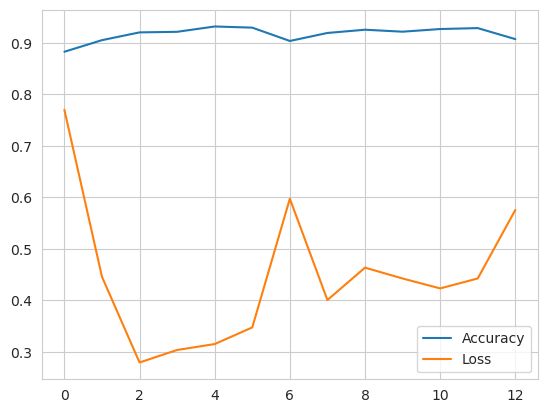

In [20]:
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(val_acc, label='Accuracy')
plt.plot(val_loss, label='Loss')
plt.legend()
plt.show()

In [21]:
predictions = np.argmax(model.predict(X_test), axis=1)

174/174 [==============================] - 13s 73ms/step


In [22]:
from sklearn.metrics import *

accuracy = accuracy_score(predictions, y_test)
precision= precision_score(predictions, y_test, average='weighted')
recall = recall_score(predictions, y_test, average='weighted')
f1_score = f1_score(predictions, y_test, average='weighted')

print("the accuracy of the model is {}".format(round(accuracy,2)))
print("the precision score  of the model is {}".format(round(precision,2)))
print("the recall score of the model is {}".format(round(recall,2)))
print("the F1-score of the model is {}".format(round(f1_score,2)))

the accuracy of the model is 0.91
the precision score  of the model is 0.92
the recall score of the model is 0.91
the F1-score of the model is 0.91


In [23]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1273
           1       0.98      0.89      0.94      1248
           2       0.92      0.86      0.89      1131
           3       0.87      0.96      0.91      1909

    accuracy                           0.91      5561
   macro avg       0.92      0.90      0.91      5561
weighted avg       0.92      0.91      0.91      5561



## Conclusion

**the model perform well on the test dataset but still need some improvment**
#### how we can improve it ?

**1- use more layers** <br> 
**2- increase the percentage of the dropout** <br>
**3- use more complix model archticture** <br>
**4- use LSTM insteed of GRU because its perform well with long sentences** <br>
**5 - resampling the data because its somehow imbalanced** <br>
**6- use pretrained model like bert or other model** <br>
**7 - decrease the range of epochs** <br>
**8 - change the learning rate parametrs**
